# Preparar el entorno


**Instalar paquetes necesarios**

In [0]:
! pip install nltk

In [0]:
!pip install requests

In [0]:
!pip install beautifulsoup4

In [0]:
!pip install Unidecode

     |████████████████████████████████| 245kB 2.7MB/s 


**Importar librerías**

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords

In [0]:
import pandas as pd
import numpy as np
import re   
import requests
import bs4
import lxml.etree as xml
import unidecode
import time
import matplotlib.pyplot as plt

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from sklearn.datasets import load_files 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud

# Preparar el dataset

**Leer archivos de excel**

In [0]:
#Obtener permisos de google drive
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
#Leer el spreadsheet del formulario de respuesta
excel_path = 'https://docs.google.com/spreadsheets/d/1jTLom8eZdrpdPY5Xby44BV7t0SrBxYZEiQ-CO4GbokY/edit#gid=147686695'
workbook = gc.open_by_url(excel_path)

#Leer la pestaña y traer todos los datos
sheet = workbook.worksheet('Leyes a incorporar')
dataFromForm = sheet.get_all_values()

In [0]:
#Creamos un dataframe con los datos tal cual los hemos leído del Excel
df_original = pd.DataFrame(dataFromForm)
df_original.columns = df_original.iloc[0]
df_original = df_original.iloc[1:]

**Crear dataset**

Crear una copia del dataset original y lo editamos para eliminar las features no relevantes


In [0]:
df_original.columns

Index(['Estado validación', 'Añadir en test', 'Id', 'Número ley',
       'Título íntegro', 'Título resumido', 'Ámbito 1', 'Ámbito 2', 'Ámbito 3',
       'Descentralización del estado', 'Economía liberal',
       'Política fiscal restrictiva', 'Ley y orden', 'Unidad de España',
       'Protección del Medio Ambiente', 'Estado del bienestar',
       'Libertades civiles y sociedad liberal', 'Fecha presentación',
       'Legislatura', 'Presentada por organismo:', 'Presentada por',
       'Contenido íntegro (Link)', 'Contenido íntegro (texto - parte 1)',
       'Contenido íntegro (texto - parte 2)',
       'Contenido íntegro (texto - parte 3)', 'Contenido resumido', 'Estado',
       'Voto Podemos', 'Voto PP', 'Voto PSOE', 'Voto C's', 'Voto VOX',
       'Voto ERC', 'Voto PNV'],
      dtype='object', name=0)

In [0]:
columnsToKeep = ['Id', 'Contenido íntegro (Link)']

In [0]:
df = df_original[columnsToKeep].copy()

In [0]:
#Comprobamos que el dataset tiene la estructura que queremos
df.head()

,Id,Contenido íntegro (Link)
1,1,http://www.congreso.es/portal/page/portal/Cong...
2,2,http://www.congreso.es/portal/page/portal/Cong...
3,3,http://www.congreso.es/portal/page/portal/Cong...
4,5,http://www.congreso.es/public_oficiales/L12/CO...
5,6,http://www.congreso.es/portal/page/portal/Cong...


# Carga del contenido de la ley

Creamos una nueva feature para albergar el contenido de la ley en formato texto.


In [0]:
#Inicializamos la nueva feature como un string vacío:
df['Contenido íntegro (texto)'] = '';

Recorremos el dataset para cargar la página cuyo link tenemos en el dataset. Para ello usamos una función que reintenta tres veces la carga de la página.

Cuando la página se carga correctamente, leemos el contenido de la ley y lo guardamos el contenido en formato texto en la feature 'Contenido íntegro (texto)'.

In [0]:
#Función para reintentar la petición de una página web
def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [0]:
#Recorremos cada fila para abrir el link con el contenido, leerlo y guardarlo en el dataset 
for index, row in df.iterrows():
  contenido_texto = ''
  URL = row['Contenido íntegro (Link)']
  if "http://www.congreso.es" in URL:
    t0 = time.time()
    try:
      response = requests_retry_session().get(URL)
      page = bs4.BeautifulSoup(response.text, "lxml")
      contenido_html = page.find(name="div", attrs={"class": "texto_completo"})
      contenido_texto = contenido_html.text
    except Exception as x:
      print('It failed :(', x.__class__.__name__)
    else:
      print('It eventually worked in row ', row['Id'], ' status: ', response.status_code)
    finally:
      t1 = time.time()
      print('Took', t1 - t0, 'seconds')
  #else:
    #contenido_texto = 'no hay contenido'
  row['Contenido íntegro (texto)'] = contenido_texto

It eventually worked in row  1  status:  200
Took 1.171010971069336 seconds
It eventually worked in row  2  status:  200
Took 1.5195188522338867 seconds
It eventually worked in row  3  status:  200
Took 1.5068068504333496 seconds
It failed :( AttributeError
Took 2.648336887359619 seconds
It eventually worked in row  6  status:  200
Took 1.4242987632751465 seconds
It failed :( AttributeError
Took 2.464679718017578 seconds
It eventually worked in row  8  status:  200
Took 0.9401962757110596 seconds
It eventually worked in row  9  status:  200
Took 1.4446732997894287 seconds
It eventually worked in row  10  status:  200
Took 1.419806718826294 seconds
It eventually worked in row  11  status:  200
Took 1.3690271377563477 seconds
It eventually worked in row  12  status:  200
Took 1.1953938007354736 seconds
It eventually worked in row  13  status:  200
Took 1.0981879234313965 seconds
It eventually worked in row  14  status:  200
Took 1.262643814086914 seconds
It eventually worked in row  15  

# Limpieza del contenido de la ley

Creamos una nueva feature para albergar el contenido de la ley limpio (sólo palabras con significado en minúsculas, sin símbolos ni acentos), que más adelante procesaremos.

Usaremos una función para limpiar el texto.

In [0]:
#Inicializamos la nueva feature como un string vacío:
df['Contenido limpio'] = ''

In [0]:
#Función para limpiar el texto
def doClean(text):   
    
    # Quitar los caracteres "\n"
    a = re.sub(r'\s+', ' ', text)
    # Quitar las expresiones entre llaves 
    a = re.sub(r'\s*{.*}\s*', ' ', str(a)) 
    # Quitar las expresiones entre paréntesis
    a = re.sub(r'\(.+\)', ' ', str(a))
    # Quitar números
    a = re.sub("\d+", ' ', str(a))
    # Quitar acentos 
    a = unidecode.unidecode(a)
    # Quitar aquello que no sean palabras o cosa que se le parezca
    a = re.sub(r'\W', ' ', a)
    # Quitar espacios extra en caso de haber
    a = re.sub(r'\s+', ' ', a, flags=re.I)
    # Pasar el texto a minúsulas
    a = a.lower()
    # retirar stopwords
    a = a.split()
    a = [ word for word in a if word not in stopwords.words('spanish')]
    a = " ".join(a)

    return a

In [0]:
#Aplicamos la función para obtener el contenido limpio
df['Contenido limpio'] = df['Contenido íntegro (texto)'].apply(doClean)

In [0]:
#Comprobamos el resultado
df.head()

,Id,Contenido íntegro (Link),Contenido íntegro (texto),Contenido limpio
1,1,http://www.congreso.es/portal/page/portal/Cong...,PROPOSICIÓN DE LEY\n\n 122/000017 Proposici...,proposicion ley proposicion ley medidas foment...
2,2,http://www.congreso.es/portal/page/portal/Cong...,PROPOSICIÓN DE LEY\n\n 122/000073 Proposici...,proposicion ley proposicion ley cierre central...
3,3,http://www.congreso.es/portal/page/portal/Cong...,PROPOSICIÓN DE LEY\n\n 122/000081 Proposici...,proposicion ley proposicion ley prohibicion us...
4,5,http://www.congreso.es/public_oficiales/L12/CO...,,
5,6,http://www.congreso.es/portal/page/portal/Cong...,PROPOSICIÓN DE LEY\n\n 122/000003 Proposici...,proposicion ley proposicion ley modifica ley d...


# Exploración

**Wordcloud del contenido de todas las leyes**

Vamos a empezar obteniendo el wordcloud del contenido de todas las leyes para identificar las palabras más importantes de forma global.

In [0]:
#Concatenamos en contenido de todas las leyes en un solo string
leyes = (" ").join(df['Contenido limpio'])

#Crear wordcloud de la ley escogida
wordcloud_leyes = WordCloud(width = 1000, height = 1000).generate(leyes) 

#Mostrar el gráfico
fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud_leyes)
plt.show()

Vemos que entre las palabras más importantes están: ley, orgánica, proposición, entrada, disposición, adicional, transitoria, entrada, vigor, fin, presente, siguiente, artículo. Estas palabras no describen el significado de la ley, y pensamos que se pueden eliminar del texto antes de obtener las palabras más importantes de cada ley.

# Borrado de palabras redundantes

Vamos a empezar obteniendo una lista de las palabras más frecuentes en todas las propuestas de ley. Si esas palabras no aportan significado, las eliminaremos de todas las leyes. De esta manera las palabras que permanezcan en el contenido de la ley servirán para discriminar una ley de otra.

Usamos TF-IDF para conocer la relevancia de las palabras del corpus. Ordenaremos los términos por relevancia y seleccionaremos las palabras que no describen la intención de la ley. Esas palabras son las "stop words" de nuestro corpus, que tenemos que aliminar para dejar sólamente las palabras significativas.

In [0]:
#Creamos el corpus: una lista con el contenido de todas las propuestas de ley
corpus = df['Contenido limpio'].tolist()

In [0]:
#Creamos el transformador
tfidf_vectorizer_0 = TfidfVectorizer(max_features=100, min_df=1, max_df=0.9)

#Generamos la matriz tf-idf del corpus y la convertimos en una lista
tf_idf_array = tfidf_vectorizer_0.fit_transform(corpus).toarray().flatten()

#Obtenemos los términos del vocabulario en forma de lista
terms_array = np.array(tfidf_vectorizer_0.get_feature_names())

#Combinamos los términos con su score tf-idf en una ley
corpus_data = list(zip(terms_array,tf_idf_array))

#Ordenamos los scores de mayor a menor
sorted_corpus_data = sorted(corpus_data,key=lambda x: x[1],reverse=True)

In [0]:
#Vemos la lista ordenada
sorted_corpus_data

A simple vista vemos que la mayoría de las palabras de la lista no expresan la intención de una ley particular. Decidimos eliminar todas ellas del contenido de todas las leyes.

In [0]:
#Obtenemos una lista de palabras sin los pesos
stop_words_corpus = [x[0] for x in sorted_corpus_data]
print(stop_words_corpus)

['ley', 'proposicion', 'dia', 'vigor', 'final', 'disposicion', 'diciembre', 'medidas', 'desarrollo', 'normativa', 'apartado', 'dispuesto', 'primera', 'disposiciones', 'gobierno', 'grupo', 'parlamentario', 'hoy', 'reunion', 'presentada', 'adoptado', 'asunto', 'indica', 'mesa', 'presente', 'acuerdo', 'camara', 'referencia', 'respecto', 'entrada', 'siguiente', 'articulo', 'entrara', 'publicacion', 'boletin', 'oficial', 'adicional', 'administracion', 'amparo', 'anos', 'aplicacion', 'asi', 'autonomas', 'caso', 'civil', 'codigo', 'competencia', 'comunidades', 'congreso', 'constitucion', 'decreto', 'derecho', 'derechos', 'diputados', 'dos', 'efectos', 'ejercicio', 'ello', 'enjuiciamiento', 'espanola', 'establecido', 'fiscal', 'forma', 'general', 'judicial', 'legislacion', 'mas', 'materia', 'meses', 'ministerio', 'modifica', 'modificacion', 'organica', 'organos', 'pagina', 'penal', 'personas', 'plazo', 'podra', 'procedimiento', 'proceso', 'publico', 'queda', 'real', 'redactado', 'regimen', 're

In [0]:
#Función para eliminar las palabras escogidas de un texto
f = lambda x: ' '.join([item for item in x.split() if item not in stop_words_corpus])

In [0]:
#Eliminación de las palabras comunes
df['Contenido limpio'] = df['Contenido limpio'].apply(f)

# Wordclouds

Vamos a obtener el wordcloud de la primera propuesta de ley para comprobar si  describe la intención de la ley.

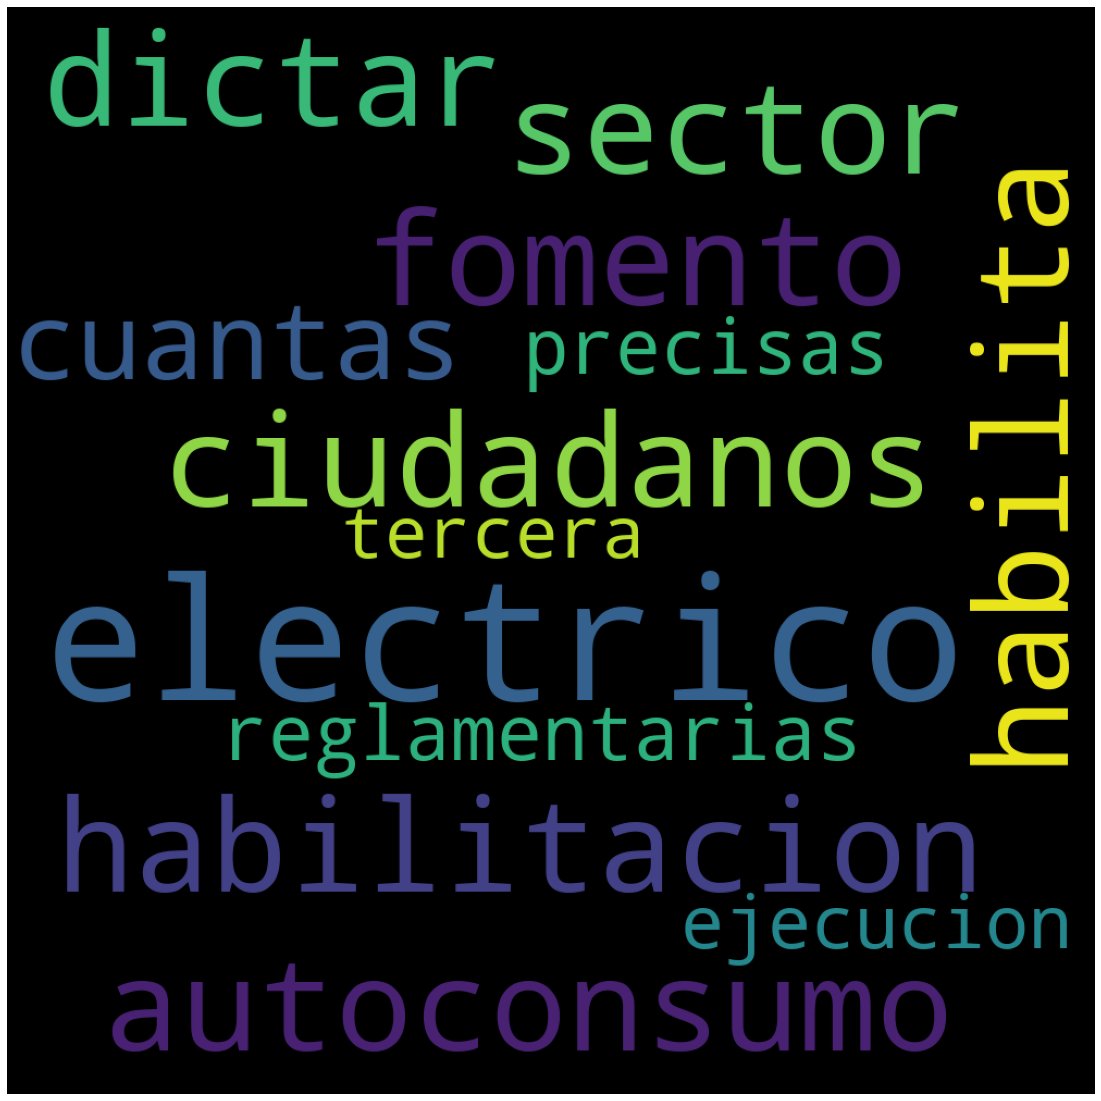

In [0]:
#Escogemos la primera ley del dataset
ley = df.iloc[0]['Contenido limpio']

#Crear wordcloud de la ley escogida
wordcloud_ley = WordCloud(width = 1000, height = 1000).generate(ley) 

#Mostrar el gráfico
fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud_ley)
plt.show()

Vemos que entre las palabrás más frecuentes se encuentran "eléctrico", "autoconsumo", "habilitación". Estas palabras describen la ley, que recoge 
medidas para el fomento del autoconsumo eléctrico.

# TF-IDF

**Obtener los k términos más importantes de cada propuesta de ley**



Generamos la matriz TF-IDF para todas las propuestas de ley. Después calculamos la relevancia de las palabras de cada propuesta individual.  Ordenamos las palabras por relevancia y seleccionamos las "n" primeras. Por último, guardamos esta lista de palabras en nuestro dataset.

In [0]:
#Inicializamos la nueva feature como un string vacío:
df['Palabras relevantes'] = ''

In [0]:
#Creamos el corpus: una lista con el contenido de todas las propuestas de ley
corpus = df['Contenido limpio'].tolist()

In [0]:
#Creamos el transformador
tfidf_vectorizer = TfidfVectorizer(max_features=None, min_df=1, max_df=0.9)

#Generamos la matriz tf-idf del corpus
tf_idf = tfidf_vectorizer.fit_transform(corpus)

#Obtenemos los términos del vocabulario
terms = tfidf_vectorizer.get_feature_names()

In [0]:
for index, row in df.iterrows():

  law = row['Contenido limpio']
  if law != '':

    #Obtenemos los scores tf-idf del contenido de una sola ley
    scored_law = tfidf_vectorizer.transform([law])

    #Combinamos los términos con su score tf-idf en la ley
    scored_law_array = scored_law.toarray().flatten().tolist()
    law_data = list(zip(terms,scored_law_array))

    #Ordenamos los scores de mayor a menor
    sorted_law_data = []
    sorted_law_data = sorted(law_data,key=lambda x: x[1],reverse=True)

    #Obtenemos una lista de palabras sin los pesos
    important_words = []
    important_words = [x[0] for x in sorted_law_data]

    #Escogemos sólo las "n" palabras más relevantes
    n = 10
    top_n = important_words[:n]
    top_n

    row['Palabras relevantes'] = top_n

  else:

    row['Palabras relevantes'] = ''

Comparamos las columnas 'Contenido íntegro (texto)' y 'Palabras relevantes'. La lista de palabras relevantes sí parece describir la motivación de la ley (nosotros conocemos las propuestas de ley e interpretamos que el resultado es satisfactorio).

In [0]:
df[['Contenido íntegro (texto)', 'Palabras relevantes']]

,Contenido íntegro (texto),Palabras relevantes
1,PROPOSICIÓN DE LEY\n\n 122/000017 Proposici...,"[electrico, autoconsumo, fomento, precisas, se..."
2,PROPOSICIÓN DE LEY\n\n 122/000073 Proposici...,"[centrales, nucleares, cierre, desmantelamient..."
3,PROPOSICIÓN DE LEY\n\n 122/000081 Proposici...,"[bases, ambiental, anexo, fractura, hidraulica..."
4,,
5,PROPOSICIÓN DE LEY\n\n 122/000003 Proposici...,"[electrica, produccion, energia, instalaciones..."
...,...,...
83,PROPOSICIÓN DE LEY\n\n 122/000050 Proposici...,"[mutualidad, beneficiarios, instituto, armadas..."
84,,
85,,
86,,


Ahora que tenemos la lista de palabras relevantes de cada propuesta de ley, podemos exportar el dataframe a un archivo excel en nuestro google drive.

In [0]:
!pip install openpyxl

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
df.to_excel('Leyes_Palabras.xlsx', sheet_name='Palabras_relevantes', index = False)

In [0]:
!cp Leyes_Palabras.xlsx "drive/My Drive/"